# Estimating photometric redshifts with RAIL stages and comparing results for different parameters

**Authors:** Jennifer Scora

**Last run successfully:** Jan 27, 2025

This notebook shows how to run through the various stages of RAIL (creation, estimation, evaluation) in order to create a simulated dataset of galaxy magnitudes and redshifts, use the magnitudes to estimate photometric redshifts, and then compare the resulting estimated photometric redshifts to the *true* redshifts. We will be using the `k-Nearest Neighbours` algorithm (for more information on this algorithm see here link) to estimate redshifts, and testing out how the limits on the number of nearest neighbours affect the resulting esimated redshift distributions. To do this, we loop over the estimation and evaluation stages while varying these parameters to test their effect. We will also then be exploring how we can parallelize this loop within the notebook to speed things up a little. However, if you are running on very large datasets, we recommend running in pipeline mode instead (link), as it is not possible to loop over large files with the interactive mode of RAIL. 

Here are the steps that we're going to cover in this notebook:

1. Creating a realistic data set of galaxy magnitudes and true redshifts 
2. Estimating the photometric redshifts
3. Summarizing the redshift distributions
4. Evaluating the photometric redshifts against the *true* values
5. Comparing the resulting redshift distributions
6. Repeating steps 2-5 with a parallelized loop

## 1. Creating a realistic data set of galaxy magnitudes and true redshifts

First we want to create the data sets of galaxy magnitudes that we will use to estimate photometric redshifts. We will use PZflow to generate our model, and then pull two data sets from the model, a training dataset and a test dataset. The training data set will be used to train our models, and the test data set is the data we will get photo-z estimates for. We'll then degrade these datasets so that they better resemble real data from the Rubin telescope. 

In [16]:
# import the packages we'll need 
import rail.interactive as ri 
import numpy as np
import tables_io
from pzflow.examples import get_galaxy_data

#plotting imports
import matplotlib.pyplot as plt 
%matplotlib inline


Here we first need to set up some column name dictionaries, as the expected column names vary between some of the codes. In order to handle this, we can pass in  dictionaries of expected column names and the column name that exists in the input data (`band_dict` and `rename_dict` below). In this notebook, we are using bands ugrizy, and each band will have a name 'mag_u_lsst', for example, with the error column name being 'mag_err_u_lsst'. 

In [4]:
bands = ["u", "g", "r", "i", "z", "y"]
band_dict = {band: f"mag_{band}_lsst" for band in bands}
rename_dict = {f"mag_{band}_lsst_err": f"mag_err_{band}_lsst" for band in bands}

Now we can grab the galaxy data we'll use to train our creation model, and we'll rename the band columns to match our desired band names as discussed above, using `band_dict`. We can check that our columns have been renamed appropriately by printing out the first few lines of the table.

In [8]:
catalog = get_galaxy_data().rename(band_dict, axis=1)
# let's take a look at the columns
catalog.head()

,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,0.287087,26.759261,25.901778,25.187710,24.932318,24.736903,24.671623
1,0.293313,27.428358,26.679299,25.977161,25.700094,25.522763,25.417632
2,1.497276,27.294001,26.068798,25.450055,24.460507,23.887221,23.206112
3,0.283310,28.154075,26.283166,24.599570,23.723491,23.214108,22.860012
4,1.545183,29.276065,27.878301,27.333528,26.543374,26.061941,25.383056


Looks good!

### Train and sample the model

Now we need to use the galaxy data we retrieved to train the model that we'll use to create our input galaxy magnitude data catalogues later. We're going to use the `PZflow` engine to do this, specifically the `modeler` function (**ADD LINK HERE**). This will train the normalizing flow that serves as the engine for the input data creation. 

We'll pass the modeler a few parameters:
- input: this is the input catalog that our modeler needs to train the data flow (the one we retrieved above)
- seed (optional): this is the random seed used for training
- phys_cols (optional): This is a dictionary of the names of the photometry columns and their corresponding [min,max] values.
- calc_colors (optional): Whether to internally calculate colors (if phot_cols are magnitudes). Assumes that you want to calculate colors from adjacent columns in phot_cols. If you do not want to calculate colors, set False. Else, provide a dictionary {‘ref_column_name’: band}, where band is a string corresponding to the column in phot_cols you want to save as the overall galaxy magnitude. We're passing in the default value here just so you can see how it works. 

In [9]:
flow_model = ri.creation.engines.flowEngine.flow_modeler(
    input=catalog,
    seed=0,
    phys_cols={"redshift": [0, 3]},
    phot_cols={
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    calc_colors={"ref_column_name": "mag_i_lsst"},
)

Inserting handle into data store.  input: None, FlowModeler
Training 30 epochs 
Loss:
(0) 21.3266
(1) 3.9686
(2) 1.9351
(3) 5.2006
(4) -0.3579
(5) 2.2561
(6) 1.5917
(7) 0.3691
(8) -1.0218
(9) inf
Training stopping after epoch 9 because training loss diverged.
Inserting handle into data store.  model: inprogress_model.pkl, FlowModeler


Now, if you take a look at the output of this function, you can see that it's a dictionary with the key 'model', since that's what we're generating, and the actual model object as the value. If there were multiple outputs for this function, they would all be collected in this dictionary. 

In [10]:
flow_model

{'model': <pzflow.flow.Flow at 0x7a23ae3c0350>}

Now we'll use the flow to produce some synthetic data for our training data set, which we'll need to train the KNN estimation algorithm later. We'll just create a small dataset of 150 galaxies for this sample, so we'll pass in the argument: `n_samples = 250`. We'll also use a specific seed for this so that it's reproducible. 

**Note that when we pass the model to this function, we don't pass the dictionary, but the actual model object. This is true of all the interactive functions.** 

In [69]:
# sample training data set from the model
train_data_orig = ri.creation.engines.flowEngine.flow_creator(
    n_samples=250, model=flow_model["model"], seed=1235
)

Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x7a23ae3c0350>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator


Now we can look at the output from this function -- as before, it's a dictionary. Here the key is 'output' instead of model, and the data is just given as a table. 

In [70]:
train_data_orig

{'output':      redshift  mag_u_lsst  mag_g_lsst  mag_r_lsst  mag_i_lsst  mag_z_lsst  \
 0    0.895023   24.430367   24.113907   23.363075   22.551493   22.109159   
 1    0.326773   25.748173   24.443707   23.225206   22.850914   22.652538   
 2    0.852999   25.977020   25.793528   25.186785   24.497295   24.103645   
 3    0.654249   29.089705   28.129740   26.982731   26.261055   25.980524   
 4    2.293210   29.600502   28.402340   27.379429   27.160976   26.637035   
 ..        ...         ...         ...         ...         ...         ...   
 245  1.015558   28.062887   27.296202   26.161701   25.183062   24.598797   
 246  2.049762   26.137064   26.092600   25.835526   25.786034   25.644787   
 247  1.432775   27.538952   27.002316   26.934074   26.385996   25.773054   
 248  0.702483   29.039577   28.428776   27.011915   26.079687   25.695610   
 249  0.491151   26.850525   25.866901   24.678297   24.320053   24.120956   
 
      mag_y_lsst  
 0     31.659264  
 1     22.3815

Now let's do the same thing, except this time we're going to grab our testing data set. This data set is our 'actual' data set, that we'll feed into the KNN estimation model to get our redshifts. Again, we'll just create a small dataset of 250 galaxies, and we'll use a different seed to ensure that the data won't be the same as the training set. 

In [73]:
# sample test data set from the model
test_data_orig = ri.creation.engines.flowEngine.flow_creator(
    model=flow_model["model"], n_samples=250, seed=1234
)

Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x7a23ae3c0350>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator


Let's check out the distributions of galaxy redshifts, just to make sure they aren't the same. 

Text(0, 0.5, 'number of galaxies')

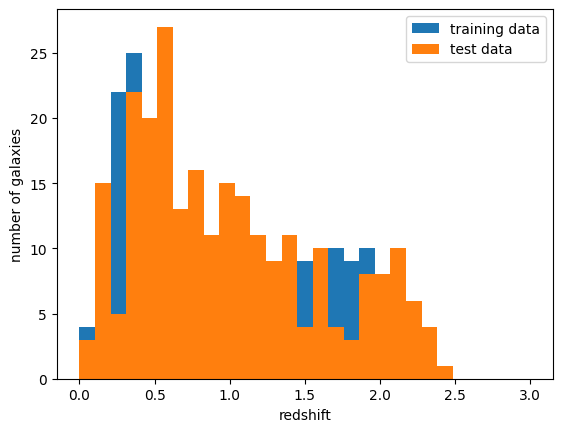

In [74]:
hist_options = {
    "bins": np.linspace(0,3,30),
    "histtype": "stepfilled"
}

plt.hist(train_data_orig["output"]["redshift"],label="training data", **hist_options)
plt.hist(test_data_orig["output"]["redshift"],label="test data", **hist_options)
plt.legend(loc="best")
plt.xlabel("redshift")
plt.ylabel("number of galaxies")

### Degrade the data sets

Next we will apply some degradation functions to the data, to make it look more like real observations. We apply the following functions to the training data set:
1. `LSSTErrorModel` to add photometric errors 
2. `InvRedshiftIncompleteness` to remove some galaxies above a redshift threshold
3. `LineConfusion` to simulate the effect of misidentified lines 
4. `QuantityCut`cuts galaxies based on their specific band magnitudes 

We then use `ColumnMapper` to rename the error columns so that they match the names in DC2, and use `TableConverter` to convert the data to a numpy dictionary, so that it fits the expected input format for the following functions. 

For the test data set, we only apply the `LSSTErrorModel` degradations, as well as making the above structural changes to get the data in the same output format as the training data set.

1. Apply the `LSSTErrorModel` to both training and test data sets. Once again, we're supplying different seeds to ensure the results are reproducible and different from each other. We are also using the `band_dict` we created earlier, which tells the code what the band column names should be. We are also supplying `ndFlag=np.nan`, which just tells the code to make non-detections `np.nan` in the output. 

In [75]:
# add photometric errors modelled on LSST to the data
train_data_errs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=train_data_orig["output"], seed=66, renameDict=band_dict, ndFlag=np.nan
)

test_data_errs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=test_data_orig["output"], seed=58, renameDict=band_dict, ndFlag=np.nan
)


Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel
Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel


In [76]:
# let's see what the output looks like 
train_data_errs["output"].head()

,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,0.895023,24.394300,0.063695,24.123357,0.017421,23.367479,0.008907,22.559692,0.007713,22.121306,0.009140,NaN,NaN
1,0.326773,25.640330,0.187487,24.418205,0.022314,23.221586,0.008178,22.848305,0.009096,22.648624,0.013263,22.384471,0.022750
2,0.852999,25.734929,0.202989,25.855284,0.078889,25.145742,0.036974,24.502724,0.034161,24.106241,0.046030,24.134585,0.106338
3,0.654249,28.755959,1.586523,27.132733,0.236458,26.997446,0.187201,26.332435,0.170326,25.882290,0.216159,25.342114,0.295019
4,2.293210,27.277291,0.667201,29.263362,1.090150,27.791085,0.357978,27.688824,0.504688,26.665804,0.405689,NaN,NaN


You can see that the error columns have been added in for each of the magnitude columns. 

Now let's take a look at what's happened to the magnitudes. Below we'll plot the u-band magnitudes before and after running the degrader. You can see that the higher magnitude objects now have a much wider variance in magnitude compared to their initial magnitudes, but at lower magnitudes they've remained similar. 

Text(0, 0.5, 'photometric errors u magnitude')

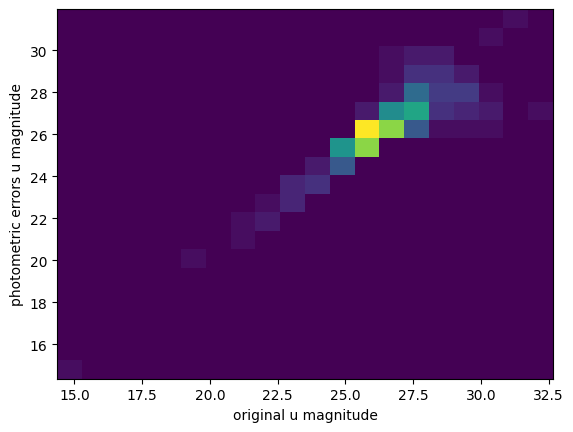

In [77]:
# we have to set the range because there are nans in the new dataset with errors, which messes up plt.hist2d 
range = [[np.min(train_data_orig["output"]["mag_u_lsst"]),np.max(train_data_orig["output"]["mag_u_lsst"])],[np.min(train_data_errs["output"]["mag_u_lsst"]),np.max(train_data_errs["output"]["mag_u_lsst"])]]
plt.hist2d(train_data_orig["output"]["mag_u_lsst"], train_data_errs["output"]["mag_u_lsst"], range=range, bins=20)
plt.xlabel("original u magnitude")
plt.ylabel("photometric errors u magnitude")

2. Use `InvRedshiftIncompleteness` to remove some galaxies above a redshift threshold. 

In [78]:
# randomly removes some galaxies above certain redshift threshold 
train_data_inc = (
    ri.creation.degraders.spectroscopic_degraders.inv_redshift_incompleteness(
        input=train_data_errs["output"], pivot_redshift=1.0
    )
)

Inserting handle into data store.  input: None, InvRedshiftIncompleteness
Inserting handle into data store.  output: inprogress_output.pq, InvRedshiftIncompleteness


Now let's take a look at what's happened to the data. We can easily see that this has resulted in a smaller sample of galaxies: instead of 150, we now only have 125.

In [79]:
print(f"Number of galaxies after cut: {len(train_data_inc["output"])}")
print(f"Number of galaxies in original: {len(train_data_errs["output"])}")

Number of galaxies after cut: 211
Number of galaxies in original: 250


Now let's plot the redshift distributions of our input and output sample. We can see that the distribution is the same below redshift 1, and above redshift 1 is where some galaxies are no longer present. 

Text(0, 0.5, 'number of galaxies')

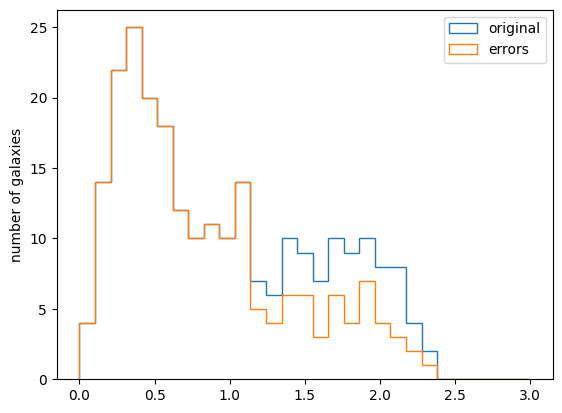

In [80]:
hist_options = {
    "bins": np.linspace(0,3,30),
    "histtype": "step"
}

plt.hist(train_data_errs["output"]["redshift"],label="original", **hist_options)
plt.hist(train_data_inc["output"]["redshift"],label="errors", **hist_options)
plt.legend(loc="best")
plt.ylabel("redshift")
plt.ylabel("number of galaxies")


3. Apply `LineConfusion` to simulate the effect of misidentified lines. The degrader will misidentify some percentage (`frac_wrong`) of the actual lines (here we're picking `true_wavelen=5007.0`, which are OIII lines) as the line we pick for `wrong_wavelen`. In this case, we'll pick `3727.0A`, which are OII lines. 

In [81]:
# simulates the effect of misidentified lines 
train_data_conf = ri.creation.degraders.spectroscopic_degraders.line_confusion(
    input=train_data_inc["output"],
    true_wavelen=5007.0,
    wrong_wavelen=3727.0,
    frac_wrong=0.05,
    seed=1337,
)

Inserting handle into data store.  input: None, LineConfusion
Inserting handle into data store.  output: inprogress_output.pq, LineConfusion


Now let's plot the distribution of redshifts we passed into this stage compared to what's been output. We can see that the output data has a few differences in the distribution, spread across the whole range of redshifts. 

Text(0, 0.5, 'number of galaxies')

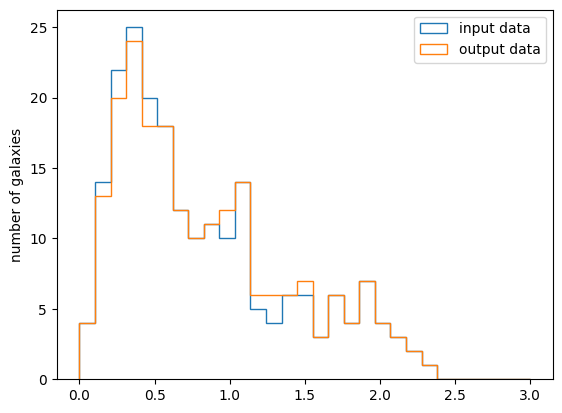

In [82]:
hist_options = {
    "bins": np.linspace(0,3,30),
    "histtype": "step"
}

plt.hist(train_data_inc["output"]["redshift"],label="input data", **hist_options)
plt.hist(train_data_conf["output"]["redshift"],label="output data", **hist_options)
plt.legend(loc="best")
plt.ylabel("redshift")
plt.ylabel("number of galaxies")

4. We use `QuantityCut` to cut galaxies based on their specific band magnitudes. This function takes a dictionary of cuts, where you can provide the band name and the values to cut that band on. If one value is given, it's considered a maximum, and if a tuple is given, it's considered a range within which the sample is selected. For this, we'll just set a maximum magnitude for the i band of 25

In [83]:
# cut some of the data below a certain magnitude 
train_data_cut = ri.creation.degraders.quantityCut.quantity_cut(
    input=train_data_conf["output"], cuts={"mag_i_lsst": 25.0}
)

Inserting handle into data store.  input: None, QuantityCut
Inserting handle into data store.  output: inprogress_output.pq, QuantityCut


Now let's check how this has affected the number of galaxies in our sample.

In [84]:
print(f"Number of galaxies after cut: {len(train_data_cut["output"])}")
print(f"Number of galaxies in original: {len(train_data_conf["output"])}")

Number of galaxies after cut: 98
Number of galaxies in original: 211


We can see that this cut the sample down significantly -- now we're under 100 galaxies! Now let's plot the distributions to see once again how they compare. 

Text(0, 0.5, 'number of galaxies')

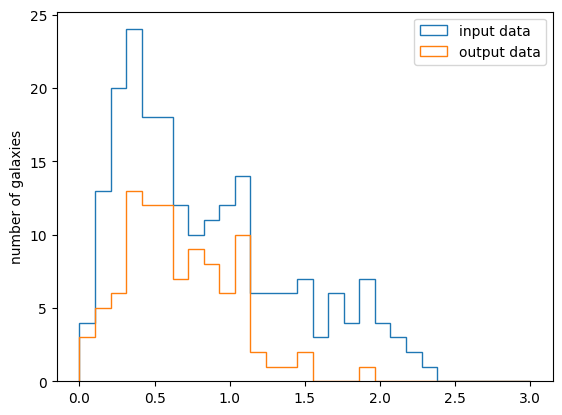

In [85]:
plt.hist(train_data_conf["output"]["redshift"],label="input data", **hist_options)
plt.hist(train_data_cut["output"]["redshift"],label="output data", **hist_options)
plt.legend(loc="best")
plt.ylabel("redshift")
plt.ylabel("number of galaxies")

Now we just need to use the dictionary we made earlier of error column names (`rename_dict`) to rename the error columns, so they match the expected names for the later steps. 

In [89]:
train_data_cut["output"].head()

,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,0.895023,24.394300,0.063695,24.123357,0.017421,23.367479,0.008907,22.559692,0.007713,22.121306,0.009140,NaN,NaN
1,0.326773,25.640330,0.187487,24.418205,0.022314,23.221586,0.008178,22.848305,0.009096,22.648624,0.013263,22.384471,0.022750
2,0.852999,25.734929,0.202989,25.855284,0.078889,25.145742,0.036974,24.502724,0.034161,24.106241,0.046030,24.134585,0.106338
7,1.952464,25.678330,0.193578,25.363119,0.051047,25.304609,0.042562,24.998636,0.053022,24.791971,0.084501,24.549107,0.152275
10,1.099573,24.765827,0.088263,24.437743,0.022690,23.956098,0.013472,23.182536,0.011411,22.630119,0.013075,22.297609,0.021119


In [92]:
# renames error columns to match DC2
train_data = ri.tools.table_tools.column_mapper(
    input=train_data_cut["output"], columns=rename_dict
)

# renames error columns to match DC2
test_data = ri.tools.table_tools.column_mapper(
    input=test_data_errs["output"], columns=rename_dict, hdf5_groupname=""
)

Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper


In [90]:
train_data_pq["output"].head()

,redshift,mag_u_lsst,mag_err_u_lsst,mag_g_lsst,mag_err_g_lsst,mag_r_lsst,mag_err_r_lsst,mag_i_lsst,mag_err_i_lsst,mag_z_lsst,mag_err_z_lsst,mag_y_lsst,mag_err_y_lsst
0,0.895023,24.394300,0.063695,24.123357,0.017421,23.367479,0.008907,22.559692,0.007713,22.121306,0.009140,NaN,NaN
1,0.326773,25.640330,0.187487,24.418205,0.022314,23.221586,0.008178,22.848305,0.009096,22.648624,0.013263,22.384471,0.022750
2,0.852999,25.734929,0.202989,25.855284,0.078889,25.145742,0.036974,24.502724,0.034161,24.106241,0.046030,24.134585,0.106338
7,1.952464,25.678330,0.193578,25.363119,0.051047,25.304609,0.042562,24.998636,0.053022,24.791971,0.084501,24.549107,0.152275
10,1.099573,24.765827,0.088263,24.437743,0.022690,23.956098,0.013472,23.182536,0.011411,22.630119,0.013075,22.297609,0.021119


Should I get rid of this? It's not necessary, as far as I can tell. The only reason is to illustrate that it exists  

In [ ]:
# converts output to a numpy dictionary
train_data = ri.tools.table_tools.table_converter(
    input=train_data_pq["output"], output_format="numpyDict"
)

# converts output to a numpy dictionary
test_data = ri.tools.table_tools.table_converter(
    input=test_data_pq["output"], output_format="numpyDict"
)


Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel
Inserting handle into data store.  input: None, InvRedshiftIncompleteness
Inserting handle into data store.  output: inprogress_output.pq, InvRedshiftIncompleteness
Inserting handle into data store.  input: None, LineConfusion
Inserting handle into data store.  output: inprogress_output.pq, LineConfusion
Inserting handle into data store.  input: None, QuantityCut
Inserting handle into data store.  output: inprogress_output.pq, QuantityCut
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper
Inserting handle into data store.  input: None, TableConverter
Inserting handle into data store.  output: inprogress_output.hdf5, TableConverter
Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LS

In [7]:
test_data_orig["output"]

,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,0.103872,22.906694,22.358709,21.818205,21.559589,21.555933,21.550838
1,0.456719,24.310820,23.649132,22.753054,22.370310,22.215559,22.098450
2,0.525806,24.664982,23.604193,22.261162,21.590563,21.268764,20.928415
3,0.541941,27.791058,27.086382,26.021805,25.579063,25.383804,25.238136
4,2.028277,27.788912,27.515602,26.852974,26.420877,25.675110,25.132336
...,...,...,...,...,...,...,...
145,0.813532,27.373718,26.486151,25.334875,24.198498,23.775885,23.441877
146,0.534561,24.474289,23.788475,22.671724,22.012754,21.821472,21.594889
147,0.964489,24.562754,24.564314,24.512400,24.182508,23.758638,23.717516
148,2.066555,26.127260,26.234278,26.086443,26.059875,25.952612,25.536114


In [8]:
len(test_data["output"]["redshift"])

150

## 2. Estimate the redshifts 
Now, we estimate our photometric redshifts. We use the [K-Nearest Neighbour algorithm](https://rail-hub.readthedocs.io/en/latest/source/estimators.html#k-nearest-neighbor) to estimate our redshifts, varying the minimum and maximum allowed number of neighbours to see its effect on the final result. To do this, we iterate over a list of the different parameter inputs we want to use for the estimator. In each loop, we:
- estimate the redshifts with the chosen parameters
- summarize the distribution of redshifts using the Naive Stacking and Point Estimate Histogram methods
- evaluate how the estimated redshifts compare to the true redshifts (the original test data set before degradation)
- save the evaluation results and summarized distributions to dictionaries so we can access them outside the loop


In [93]:
### Iterate over estimating photo-zs using KNN 

# set up parameters to iterate over and dictionaries to store data
nb_params = [(3,7), (2,6), (2,8), (4,9)]
eval_dict = {}
naive_dict = {}
point_est_dict = {}

for nb_min, nb_max in nb_params:
    # train the informer
    inform_knn = ri.estimation.algos.k_nearneigh.k_near_neig_informer(
        input=train_data["output"], nondetect_val=np.nan, model="bpz.pkl", hdf5_groupname="", nneigh_min=nb_min, nneigh_max=nb_max
    )
    # get photo-zs
    knn_estimated = ri.estimation.algos.k_nearneigh.k_near_neig_estimator(
        input=test_data["output"],
        model=inform_knn["model"],
        nondetect_val=np.nan,
        hdf5_groupname="",
    )

    ### Evaluate the results 
    evaluator_stage_dict = dict(
        metrics=["cdeloss", "pit", "brier"],
        _random_state=None,
        metric_config={
            "brier": {"limits": (0, 3.1)},
            "pit": {"tdigest_compression": 1000},
        },
    )
    truth = test_data_orig

    the_eval = ri.evaluation.dist_to_point_evaluator.dist_to_point_evaluator(
            input={"data": knn_estimated["output"], "truth": truth["output"]
            },
            **evaluator_stage_dict,
            hdf5_groupname="",
        )
    
    # put the evaluation results in a dictionary so we have them 
    eval_dict[(nb_min,nb_max)] = the_eval

    # summarize the distributions using point estimate and naive stack summarizers 
    point_estimate_ens = ri.estimation.algos.point_est_hist.point_est_hist_summarizer(
    input=knn_estimated["output"]
    )
    point_est_dict[(nb_min,nb_max)] = point_estimate_ens
    naive_stack_ens = ri.estimation.algos.naive_stack.naive_stack_summarizer(
        input=knn_estimated["output"]
    )
    naive_dict[(nb_min,nb_max)] = naive_stack_ens





Inserting handle into data store.  input: None, KNearNeighInformer
split into 74 training and 24 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.075 and numneigh=7



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x5bf3ad0a3920>, 'bestsig': np.float64(0.075), 'nneigh': 7, 'truezs': array([0.89502305, 0.32677305, 0.85299897, 1.95246434, 1.09957254,
       0.43567419, 1.0787313 , 0.26179814, 0.3814137 , 1.00822675,
       1.48816133, 0.24501657, 0.15997183, 0.37873769, 0.27315104,
       0.51164258, 0.35596585, 0.82924354, 1.51419733, 0.82626295,
       0.89153641, 1.10178828, 0.77172345, 0.20382369, 0.56159049,
       1.01075983, 1.33381254, 0.7057181 , 0.83834368, 0.45471513,
       0.09825778, 0.74677867, 0.9069888 , 0.54044455, 0.51429349,
       0

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 250
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 250
Inserting handle into data store.  output: inprogress_output.hdf5, NaiveStackSummarizer
Ins

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 250
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 250
Inserting handle into data store.  output: inprogress_output.hdf5, NaiveStackSummarizer
Ins

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 250
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 250
Inserting handle into data store.  output: inprogress_output.hdf5, NaiveStackSummarizer
Ins

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 250
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 250
Inserting handle into data store.  output: inprogress_output.hdf5, NaiveStackSummarizer
Ins

In [94]:
point_est_dict[(3,7)]

{'output': Ensemble(the_class=hist,shape=(1000, 301)),
 'single_NZ': Ensemble(the_class=hist,shape=(1, 301))}

In [95]:
point_est_dict[(3,7)]['single_NZ']

Ensemble(the_class=hist,shape=(1, 301))

## Compare the results

We can take a look at the evaluation metrics that we've generated for each of the runs to see how they compare 

In [96]:
# TODO: either make this into a nicer table or just print out the dictionary?
results_tables = {
    key: tables_io.convertObj(val["summary"], tables_io.types.PD_DATAFRAME)
    for key, val in eval_dict.items()
}
results_tables

{(3,
  7):     cdeloss       brier
 0 -0.727009  161.932511,
 (2,
  6):    cdeloss       brier
 0 -0.71507  170.678668,
 (2,
  8):     cdeloss       brier
 0 -0.740922  155.310557,
 (4,
  9):     cdeloss       brier
 0 -0.761358  149.471389}

In [97]:
eval_dict

{(3, 7): {'output': {},
  'summary': {'cdeloss': array([-0.72700935]), 'brier': array([161.9325107])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 89))}},
 (2, 6): {'output': {},
  'summary': {'cdeloss': array([-0.71506983]), 'brier': array([170.67866811])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 89))}},
 (2, 8): {'output': {},
  'summary': {'cdeloss': array([-0.74092205]), 'brier': array([155.31055711])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 89))}},
 (4, 9): {'output': {},
  'summary': {'cdeloss': array([-0.76135757]), 'brier': array([149.47138943])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 90))}}}

We can also plot the summarized distributions of all the photometric redshifts generated in a loop against each other, to compare the effect of the different parameters. Below, we plot the runs with the following parameters, since they have the most different evaluation metrics: 
- minimum neighbours: 3, maximum neighbours: 7
- minimum neighbours: 4, maximum neighbours: 9

Text(0, 0.5, 'p(z)')

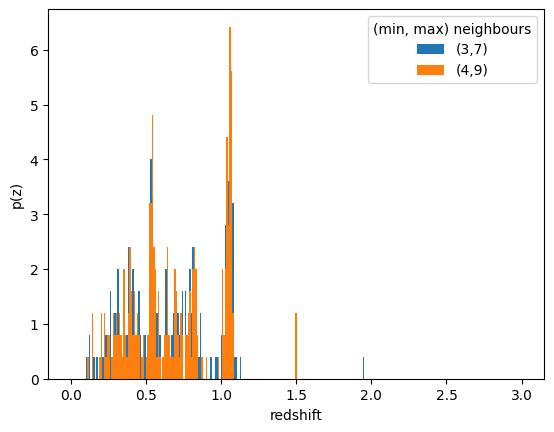

In [98]:
# get bin centers and widths 
bin_width = point_est_dict[(3,7)]["single_NZ"].metadata["bins"][1] - point_est_dict[(3,7)]["single_NZ"].metadata["bins"][0]
bin_centers = (point_est_dict[(3,7)]["single_NZ"].metadata["bins"][:-1] + point_est_dict[(3,7)]["single_NZ"].metadata["bins"][1:])/2

# plot both histograms to compare
plt.bar(bin_centers,point_est_dict[(3,7)]["single_NZ"].objdata["pdfs"],width=bin_width,label="(3,7)")
plt.bar(bin_centers,point_est_dict[(4,9)]["single_NZ"].objdata["pdfs"],width=bin_width,label="(4,9)")
plt.legend(loc="best", title="(min, max) neighbours")
plt.xlabel("redshift")
plt.ylabel("p(z)")

Text(0, 0.5, 'p(z)')

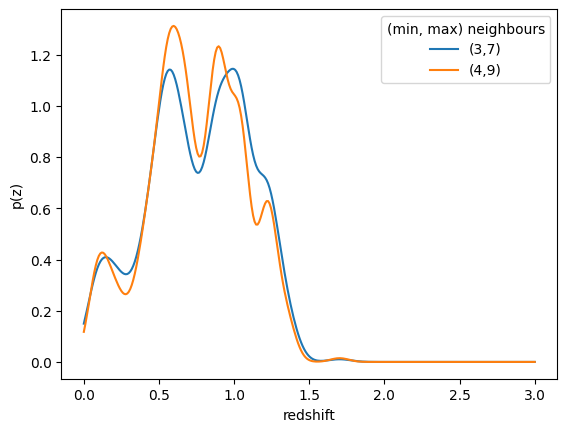

In [28]:
# Plot of naive stack summarized distribution 
plt.plot(naive_dict[(3,7)]["single_NZ"].metadata["xvals"], naive_dict[(3,7)]["single_NZ"].objdata["yvals"],label="(3,7)")
plt.plot(naive_dict[(4,9)]["output"].metadata["xvals"], naive_dict[(4,9)]["single_NZ"].objdata["yvals"],label="(4,9)")

plt.legend(loc="best", title="(min, max) neighbours")
plt.xlabel("redshift")
plt.ylabel("p(z)")

## Using multiprocessing

Let's say we wanted to do the same as above but with a lot more parameters (and perhaps with a slower algorithm). We can use the python `multiprocessing` module to run the whole loop concurrently, and speed up the process a little. To do this, we need to turn our loop above into its own function. 

In [ ]:
def estimate_photoz(nb_lims):
    """A function to estimate photo-zs using the KNN alorithm, given a minimum and maximum number of nearest neighbours. It will 
    then evaluate the performance """

    # nb_lims, train_data, test_data, inform_knn, test_data_orig = args[0], args[1][0], args[1][1], args[1][2]

    # train the informer
    inform_knn = ri.estimation.algos.k_nearneigh.k_near_neig_informer(
        input=train_data["output"], nondetect_val=np.nan, model="bpz.pkl", hdf5_groupname="", nneigh_min=nb_lims[0], nneigh_max=nb_lims[1]
    )
    # get photo-zs
    knn_estimated = ri.estimation.algos.k_nearneigh.k_near_neig_estimator(
        input=test_data["output"],
        model=inform_knn["model"],
        nondetect_val=np.nan,
        hdf5_groupname="",
    )
   
    ### Evaluate the results 
    evaluator_stage_dict = dict(
        metrics=["cdeloss", "pit", "brier"],
        _random_state=None,
        metric_config={
            "brier": {"limits": (0, 3.1)},
            "pit": {"tdigest_compression": 1000},
        },
    )
    truth = test_data_orig

    the_eval = ri.evaluation.dist_to_point_evaluator.dist_to_point_evaluator(
            input={"data": knn_estimated["output"], "truth": truth["output"]
            },
            **evaluator_stage_dict,
            hdf5_groupname="",
        )
    
    # put the evaluation results in a dictionary so we have them 
    # eval_dict_lg[(nb_lims[0],nb_lims[1])] = the_eval

    # summarize the distributions using point estimate and naive stack summarizers 
    point_estimate_ens = ri.estimation.algos.point_est_hist.point_est_hist_summarizer(
    input=knn_estimated["output"]
    )
    # point_est_dict_lg[(nb_lims[0],nb_lims[1])] = point_estimate_ens
    naive_stack_ens = ri.estimation.algos.naive_stack.naive_stack_summarizer(
        input=knn_estimated["output"]
    )
    # naive_dict_lg[(nb_lims[0],nb_lims[1])] = naive_stack_ens
    return nb_lims, the_eval, point_estimate_ens, naive_stack_ens

In [ ]:
from multiprocessing.pool import ThreadPool as Pool

# set up parameters to iterate over and dictionaries to store data
nb_params = [(3,7), (2,6), (2,8), (4,9), (5,10), (1,9), (2,9), (3,10)]
nb_mins = [3,2,2,4,5,1,2,3]
nb_maxs = [7,6,8,9,10,9,9,10]
eval_dict_lg = {}
naive_dict_lg = {}
point_est_dict_lg = {}

pool = Pool(4) # use 4 cores 
for result in pool.imap_unordered(estimate_photoz, nb_params):
    eval_dict_lg[result[0]] = result[1]
    point_est_dict_lg[result[0]] = result[2]
    naive_dict_lg[result[0]] = result[3]

Inserting handle into data store.  input: None, KNearNeighInformer
split into 48 training and 16 validation samples
finding best fit sigma and NNeigh...
Inserting handle into data store.  input: None, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighInformer
split into 48 training and 16 validation samples
finding best fit sigma and NNeigh...
split into 48 training and 16 validation samples
finding best fit sigma and NNeigh...
Inserting handle into data store.  input: None, KNearNeighInformer
split into 48 training and 16 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e6ec080ba0>, 'bestsig': np.float64(0.075), 'nneigh': 3, 'truezs': array([0.8559624 ,

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150


Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150



best fit values are sigma=0.075 and numneigh=4



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e7740bcb20>, 'bestsig': np.float64(0.075), 'nneigh': 4, 'truezs': array([0.8559624 , 1.09725535, 0.67563593, 0.91550589, 0.90324795,
       0.65226948, 0.77357709, 0.37648416, 1.22105432, 0.89333856,
       0.65628129, 0.83754033, 1.04881907, 1.19360622, 0.41372049,
     

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e7600170d0>, 'bestsig': np.float64(0.075), 'nneigh': 3, 'truezs': array([0.8559624 , 1.09725535, 0.67563593, 0.91550589, 0.90324795,
       0.65226948, 0.77357709, 0.37648416, 1.22105432, 0.89333856,
       0.65628129, 0.83754033, 1.04881907, 1.19360622, 0.41372049,
       0.07890534, 0.33354044, 0.84880698, 0.50793141, 0.07312357,
       0.92710775, 0.53522396, 0.78664237, 0.55667555, 0.45270801,
       0.50885946, 1.21598339, 0.55211103, 0.22890699, 0.49027538,
       0.60366631, 0.66702271, 0.59513855, 

Inserting handle into data store.  output: inprogress_output.hdf5, KNearNeighEstimator
Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 150
Inse

Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e780064c40>, 'bestsig': np.float64(0.075), 'nneigh': 3, 'truezs': array([0.8559624 , 1.09725535, 0.67563593, 0.91550589, 0.90324795,
       0.65226948, 0.77357709, 0.37648416, 1.22105432, 0.89333856,
       0.65628129, 0.83754033, 1.04881907, 1.19360622, 0.41372049,
     

Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e76007a170>, 'bestsig': np.float64(0.075), 'nneigh': 3, 'truezs': array([0.8559624 , 1.09725535, 0.67563593, 0.91550589, 0.90324795,
       0.65226948, 0.77357709, 0.37648416, 1.22105432, 0.89333856,
       0.65628129, 0.83754033, 1.04881907, 1.19360622, 0.41372049,
     

Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e774127080>, 'bestsig': np.float64(0.075), 'nneigh': 3, 'truezs': array([0.8559624 , 1.09725535, 0.67563593, 0.91550589, 0.90324795,
       0.65226948, 0.77357709, 0.37648416, 1.22105432, 0.89333856,
       0.65628129, 0.83754033, 1.04881907, 1.19360622, 0.41372049,
     

Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running est

### Comparing results

Now we can take a look at the dictionary of evaluation metrics, and compare the reuslts for the different parameters

In [26]:
eval_dict_lg

{(3, 7): {'output': {},
  'summary': {'cdeloss': array([-0.3212951]), 'brier': array([197.25699163])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 91))}},
 (2, 6): {'output': {},
  'summary': {'cdeloss': array([-0.3212951]), 'brier': array([197.25699163])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 91))}},
 (4, 9): {'output': {},
  'summary': {'cdeloss': array([-0.4916678]), 'brier': array([174.23508633])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 90))}},
 (2, 8): {'output': {},
  'summary': {'cdeloss': array([-0.3212951]), 'brier': array([197.25699163])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 91))}},
 (5, 10): {'output': {},
  'summary': {'cdeloss': array([-0.60446155]), 'brier': array([153.90551802])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 92))}},
 (1, 9): {'output': {},
  'summary': {'cdeloss': array([-0.3212

Let's plot the distributinos of two different runs with different evalutation metrics to see what was different:

<Axes: xlabel='redshift', ylabel='p(z)'>

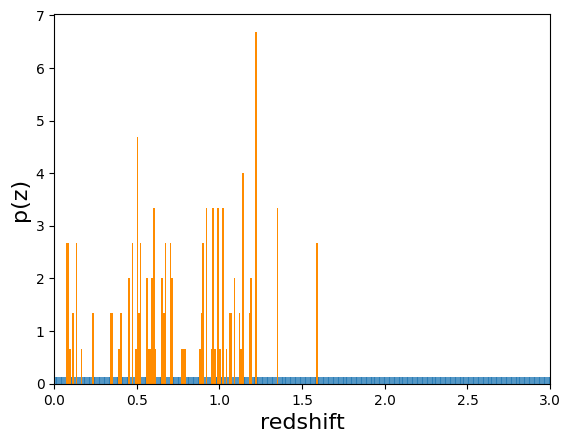

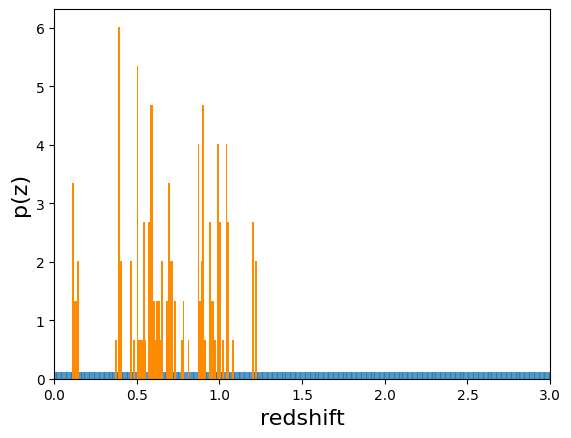

In [27]:
# Plot of naive stack summarized distribution 
point_est_dict_lg[(3,7)]["output"].plot_native(xlim=(0,3))
point_est_dict_lg[(5,10)]["output"].plot_native(xlim=(0,3))

### Large datasets

If the code is slow because you're using extremely large datasets, or you're running into memory issues for the same reason, then we suggest using a pipeline. Pipelines are ideal for large datasets, as the code will chunk up large files and iterate through them as needed. 